<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Numba" data-toc-modified-id="Numba-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Numba</a></span><ul class="toc-item"><li><span><a href="#jit与njit" data-toc-modified-id="jit与njit-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>jit 与 njit</a></span></li><li><span><a href="#Loops" data-toc-modified-id="Loops-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Loops</a></span></li><li><span><a href="#FastMath" data-toc-modified-id="FastMath-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>FastMath</a></span></li><li><span><a href="#Parallel" data-toc-modified-id="Parallel-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Parallel</a></span></li></ul></li><li><span><a href="#JAX" data-toc-modified-id="JAX-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>JAX</a></span><ul class="toc-item"><li><span><a href="#替换NumPy" data-toc-modified-id="替换NumPy-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>替换 NumPy</a></span></li><li><span><a href="#jit" data-toc-modified-id="jit-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>jit</a></span></li><li><span><a href="#grad" data-toc-modified-id="grad-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>grad</a></span></li><li><span><a href="#vmap" data-toc-modified-id="vmap-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>vmap</a></span></li></ul></li><li><span><a href="#Cython" data-toc-modified-id="Cython-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cython</a></span><ul class="toc-item"><li><span><a href="#annotate" data-toc-modified-id="annotate-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>annotate</a></span></li><li><span><a href="#cfunc/cdef" data-toc-modified-id="cfunc/cdef-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>cfunc/cdef</a></span></li><li><span><a href="#性能对比" data-toc-modified-id="性能对比-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>性能对比 </a></span></li></ul></li><li><span><a href="#CuPy" data-toc-modified-id="CuPy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CuPy</a></span><ul class="toc-item"><li><span><a href="#cupy.ndarray" data-toc-modified-id="cupy.ndarray-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>cupy.ndarray</a></span></li><li><span><a href="#Device" data-toc-modified-id="Device-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Device</a></span></li><li><span><a href="#Data-Transfer" data-toc-modified-id="Data-Transfer-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Data Transfer</a></span></li><li><span><a href="#Memory" data-toc-modified-id="Memory-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Memory</a></span></li></ul></li><li><span><a href="#Sparse" data-toc-modified-id="Sparse-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sparse</a></span><ul class="toc-item"><li><span><a href="#创建" data-toc-modified-id="创建-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>创建 </a></span></li><li><span><a href="#转换" data-toc-modified-id="转换-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>转换 </a></span></li><li><span><a href="#计算" data-toc-modified-id="计算-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>计算 </a></span></li></ul></li><li><span><a href="#Dask" data-toc-modified-id="Dask-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dask</a></span><ul class="toc-item"><li><span><a href="#创建" data-toc-modified-id="创建-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>创建 </a></span></li><li><span><a href="#索引" data-toc-modified-id="索引-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>索引 </a></span></li><li><span><a href="#计算" data-toc-modified-id="计算-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>计算 </a></span></li><li><span><a href="#任务图" data-toc-modified-id="任务图-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>任务图 </a></span></li><li><span><a href="#底层API" data-toc-modified-id="底层API-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>底层 API</a></span></li><li><span><a href="#调度" data-toc-modified-id="调度-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>调度 </a></span></li><li><span><a href="#性能对比" data-toc-modified-id="性能对比-6.7"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>性能对比 </a></span></li></ul></li><li><span><a href="#Xarray" data-toc-modified-id="Xarray-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Xarray</a></span><ul class="toc-item"><li><span><a href="#创建" data-toc-modified-id="创建-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>创建 </a></span></li><li><span><a href="#索引" data-toc-modified-id="索引-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>索引 </a></span></li><li><span><a href="#属性" data-toc-modified-id="属性-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>属性 </a></span></li><li><span><a href="#计算" data-toc-modified-id="计算-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>计算 </a></span></li><li><span><a href="#GroupBy" data-toc-modified-id="GroupBy-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>GroupBy</a></span></li><li><span><a href="#可视化" data-toc-modified-id="可视化-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>可视化 </a></span></li></ul></li><li><span><a href="#小结" data-toc-modified-id="小结-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>小结 </a></span></li><li><span><a href="#参考" data-toc-modified-id="参考-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>参考 </a></span></li></ul></div>

In [1]:
import numpy as np
np.__version__

'1.22.4'

文档阅读说明：

- 🐧 表示 Tip
- ⚠️ 表示注意事项

本部分内容主要介绍与NumPy相关的高性能、分布式数值计算用法和工具。它们的安装都比较简单，参考文档即可。我们这里侧重介绍一下每个工具是干什么的，有什么特点，我们什么时候需要使用它们。

## Numba


文档：[Numba documentation — Numba 0.55.2+0.g2298ad618.dirty-py3.7-linux-x86_64.egg documentation](https://numba.readthedocs.io/en/stable/index.html)

Numba是适用于Python的即时编译器，最适合用在使用NumPy数组和函数，以及循环的代码中。最常用的使用方法是通过装饰器。当调用一个Numba的装饰器时，它会被编译为「即时」的机器代码以供执行，全部或部分代码随后可以以机器代码的速度运行。

概括来说，这几种情况适合使用Numba：

- 很多数学计算
- 使用了很多Numpy
- 有很多循环

它的原理是，通过读取装饰函数的Python字节码，并将其与函数输入的参数类型信息相结合，分析和优化代码后，使用LLVM编译器根据CPU定制生成函数的机器代码版本。之后的调用都会使用该编译后的版本。

In [2]:
from numba import jit

In [14]:
def func_normal(a):
    x = np.median(a)
    y = np.max(a)
    t = x / y;
    z = x * np.sqrt(1 + t * t)
    m = 0.0
    for i in range(a.shape[0]):
        m += np.tanh(a[i, i])
        m /= z
    return a + m

In [6]:
a = np.arange(100, dtype=np.int32).reshape(10, 10)

In [15]:
%timeit func_normal(a)

68.2 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
@jit(nopython=True)
def func_numba(a):
    x = np.median(a)
    y = np.max(a)
    t = x / y;
    z = x * np.sqrt(1 + t * t)
    m = 0.0
    for i in range(a.shape[0]):
        m += np.tanh(a[i, i])
        m /= z
    return a + m

In [19]:
prebuild = func_numba(a)

In [20]:
%timeit func_numba(a)

1.68 µs ± 33.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


可以很明显看出性能的提升。

### jit与njit

`Numba`有两种模式：

- `nopython`模式：用`@jit(nopython=True)`或`@njit`装饰器装饰。这种模式下，函数将完全在编译模式下运行，不需要Python解释器参与。这也是`Numba`推荐的使用方式。
- `object`模式：直接用`@jit`装饰时，如果`nopython`模式失败，则会使用`object`模式进行编译，此时一部分可「Numba」的代码会使用机器代码执行，剩下的则使用Python编译器执行。

In [3]:
from numba import njit
import pandas as pd

In [4]:
@njit
def jit_fail(x):
    df = pd.DataFrame(x)
    df += 1
    cov = df.cov()
    return cov

In [5]:
x = {'a': [1, 2, 3], 'b': [20, 30, 40]}

In [6]:
jit_fail(x)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1m[1] During: typing of argument at <ipython-input-4-481c7b069f0d> (3)[0m
[1m
File "<ipython-input-4-481c7b069f0d>", line 3:[0m
[1mdef jit_fail(x):
[1m    df = pd.DataFrame(x)
[0m    [1m^[0m[0m

This error may have been caused by the following argument(s):
- argument 0: [1mcannot determine Numba type of <class 'dict'>[0m


In [7]:
@jit
def jit_succ(x):
    df = pd.DataFrame(x)
    df += 1
    cov = df.cov()
    return cov

In [8]:
# 会有警告
cov = jit_succ(x)

<ipython-input-7-cb5f8409f203>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "jit_succ" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-7-cb5f8409f203> (3)

File "<ipython-input-7-cb5f8409f203>", line 3:
def jit_succ(x):
    df = pd.DataFrame(x)
    ^

  @jit
/usr/local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "jit_succ" was compiled in object mode without forceobj=True.

File "<ipython-input-7-cb5f8409f203>", line 2:
@jit
def jit_succ(x):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/usr/local/lib/python3.8/site-packages/numba/core/object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-o

In [13]:
%timeit jit_succ(x)

559 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
def func(x):
    df = pd.DataFrame(x)
    df += 1
    cov = df.cov()
    return cov

In [14]:
%timeit func(x)

514 µs ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


此时性能差不多，`Numba`反而会慢一些，因为它还要判断是不是可以编译优化。

[官方文档](https://numba.readthedocs.io/en/stable/user/5minguide.html#other-things-of-interest)还有其他一些特性，不过我们主要关注和性能相关的几个。

### Loops

`Numba`对循环可以进行优化：

In [116]:
def get_primes(x):
    res = []
    for v in range(x+1):
        if v < 2:
            continue
        flag = True
        for i in range(2, int(np.sqrt(v)) + 1):
            if v % i == 0:
                flag = False
        if flag:
            res.append(v)
    return res

In [117]:
is_prime(10)

[2, 3, 5, 7]

In [118]:
x = 100000

In [119]:
%timeit get_primes(x)

1.28 s ± 48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
@njit
def jit_get_primes(x):
    res = []
    for v in range(x+1):
        if v < 2:
            continue
        flag = True
        for i in range(2, int(np.sqrt(v)) + 1):
            if v % i == 0:
                flag = False
        if flag:
            res.append(v)
    return res

In [121]:
prebuild = jit_get_primes(x)

In [122]:
%timeit jit_get_primes(x)

77.7 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


可以看出效果还是很明显的，不过我们在使用时尽量做一下性能对比，以做到心中有数。

### FastMath

在某些情况下，可以通过放松一些严格的（IEEE754）数值获得额外的性能提升。

>IEEE 二进制浮点数算术标准（ IEEE 754 ）是 20 世纪 80 年代以来最广泛使用的浮点数运算标准，为许多 CPU 与 浮点运算器所采用。这个标准定义了表示浮点数的格式（包括负零 -0）与反常值（denormal number），一些特殊数值（（ 无穷（Inf）与非数值（NaN）），以及这些数值的 “浮点数运算符”；它也指明了四种数值舍入规则和五种例外状况（包括例外发生的时机与处理方式）。——维基百科

以官方文档例子来说明：

In [205]:
@njit(fastmath=False)
def do_sum(A):
    acc = 0.
    # without fastmath, this loop must accumulate in strict order
    for x in A:
        acc += np.sqrt(x)
    return acc

@njit(fastmath=True)
def do_sum_fast(A):
    acc = 0.
    # with fastmath, the reduction can be vectorized as floating point
    # reassociation is permitted.
    for x in A:
        acc += np.sqrt(x)
    return acc

In [206]:
a = np.arange(40000)

In [207]:
prebuild1 = do_sum(a)
prebuild2 = do_sum_fast(a)

In [208]:
prebuild1, prebuild2

(5333233.1256554425, 5333233.1256554425)

In [209]:
%timeit do_sum(a)

70 µs ± 678 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [210]:
%timeit do_sum_fast(a)

53.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


默认情况下，编译器在浮点优化方面收到严格限制（如重新关联浮点表达式），因为这样的优化可能导致结果改变。比如：

- (10000001.0f * 10000001.0f) / 10000001.0f == 10000000.0f
- 10000001.0f * (10000001.0f / 10000001.0f) == 10000001.0f

第一个表达式括号里的会超出32位精度，会舍入。

更多关于这方面的知识可以参考：

- [SIMD vectorization](https://arcb.csc.ncsu.edu/~mueller/cluster/ps3/SDK3.0/docs/accessibility/sdkpt/cbet_1simdvector.html)
- [Floating Point Optimization](https://software-dl.ti.com/ccs/esd/documents/sdto_cgt_floating_point_optimization.html)

### Parallel

In [199]:
from numba import prange

In [211]:
@njit(parallel=True)
def do_sum_parallel(A):
    # each thread can accumulate its own partial sum, 
    # and then a cross
    # thread reduction is performed to obtain the result to return
    n = len(A)
    acc = 0.
    for i in prange(n):
        acc += np.sqrt(A[i])
    return acc

@njit(parallel=True, fastmath=True)
def do_sum_parallel_fast(A):
    n = len(A)
    acc = 0.
    for i in prange(n):
        acc += np.sqrt(A[i])
    return acc

In [212]:
prebuild1 = do_sum_parallel(a)
prebuild2 = do_sum_parallel_fast(a)
prebuild1, prebuild2

(5333233.125655441, 5333233.125655442)

In [213]:
%timeit do_sum_parallel(a)

108 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [214]:
%timeit do_sum_parallel_fast(a)

95.5 µs ± 3.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## JAX


文档：[JAX Quickstart — JAX documentation](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)

JAX是运行在CPU、GPU和TPU上的NumPy，两者关系：

- JAX提供了一个方便的受NumPy启发的接口。
- 通过鸭子类型，JAX数组通常可以直接替代NumPy数组。
- 与NumPy数组不同，JAX数组是不可变的。

### 替换NumPy

In [215]:
import jax.numpy as jnp

In [216]:
jnp.arange(10)

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [217]:
list(_)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [218]:
from jax import random

In [221]:
key = random.PRNGKey(42)

In [223]:
a = random.normal(key, (2, 3))
a

DeviceArray([[ 0.61226517,  1.1225883 ,  1.1373315 ],
             [-0.81273264, -0.8904051 ,  0.12623137]], dtype=float32)

In [224]:
b = random.normal(key, (3, 2))
b

DeviceArray([[ 0.61226517,  1.1225882 ],
             [ 1.1373315 , -0.8127326 ],
             [-0.8904051 ,  0.12623137]], dtype=float32)

In [225]:
jnp.dot(a, b)

DeviceArray([[ 0.63893783, -0.08147554],
             [-1.6226908 , -0.1727684 ]], dtype=float32)

In [226]:
np.dot(a, b)

array([[ 0.63893783, -0.08147555],
       [-1.6226908 , -0.1727684 ]], dtype=float32)

### jit

`jit`主要用来加速。

In [227]:
from jax import jit

In [232]:
def func_normal(a):
    x = jnp.median(a)
    y = jnp.max(a)
    t = x / y;
    z = x * jnp.sqrt(1 + t * t)
    m = 0.0
    for i in range(a.shape[0]):
        m += jnp.tanh(a[i, i])
        m /= z
    return a + m

In [233]:
a = np.arange(100, dtype=np.int32).reshape(10, 10)

In [235]:
pre = jit(func_normal)(a)

In [238]:
%timeit func_normal(a)

5.83 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [236]:
%timeit jit(func_normal)(a)

42.5 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### grad

`grad`用来计算导数。

In [240]:
from jax import grad

以Sigmoid函数为例：

$$
f(x) = \frac{1}{1+e^{-x}}
$$

它的导数为：`f(x) * (1-f(x))`。

In [245]:
def sigmoid(x):
    return 1.0 / (1.0 + jnp.exp(-x))

In [253]:
def dsigmoid(x):
    x = sigmoid(x)
    return x * (1-x)

In [254]:
dersigmoid = grad(sigmoid)

In [255]:
dersigmoid(2.)

DeviceArray(0.10499357, dtype=float32)

In [256]:
dsigmoid(2.)

DeviceArray(0.10499363, dtype=float32)

### vmap

`vmap`用于自动向量化或批量化。以官方文档为例：

In [258]:
mat = random.normal(key, (150, 100))

In [259]:
batched_x = random.normal(key, (10, 100))

首先看简单循环版：

In [260]:
def apply_matrix(v):
    return jnp.dot(mat, v)

In [261]:
def naive_batched(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])

In [265]:
naive_batched(batched_x).shape

(10, 150)

In [275]:
%timeit naive_batched(batched_x).block_until_ready()

3.78 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


接下来是矩阵乘法（手动Batch）版：

In [276]:
def batched_apply_matrix(v_batched):
    return jnp.dot(v_batched, mat.T)

In [277]:
%timeit batched_apply_matrix(batched_x).block_until_ready()

226 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


最后是`vmap`：

In [278]:
from jax import vmap, jit

In [281]:
@jit
def vmap_apply_matrix(v_batched):
    return vmap(apply_matrix)(v_batched)

In [282]:
%timeit vmap_apply_matrix(batched_x).block_until_ready()

18.9 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


这在没法使用矩阵乘法的时候非常有用。

最后值得一提的是，三个方法乃至`jnp`既可以单独使用，也可以联合起来使用。实际使用时可以根据自己的需要灵活组合。

这里我们简单介绍一下，更多内容可以进一步阅读文档。

## Cython

[Welcome to Cython’s Documentation — Cython 3.0.0a10 documentation](https://cython.readthedocs.io/en/latest/)

Cython在本章中都比较特别，它是一种编程语言，使得编写C扩展像Python一样容易。它旨在成为Python的超集，赋予它高级、面向对象和动态编程。Cython代码会被翻译成优化的C/C++代码并编译为Python扩展模块。不仅使得程序执行与C语言紧密集成，同时保持Python的易开发性。

看个最简单的例子：

In [5]:
# 加载扩展
%load_ext Cython

In [47]:
%%cython

cdef int a = 0
for i in range(10):
    a += i
print(a)

45


### annotate

可以使用`annotate`选项查看代码分析：

In [48]:
%%cython --annotate

cdef int a = 0
for i in range(10):
    a += i
print(a)

45


下面显示的是纯Python版，不过这种情况下需要类型标记。

In [49]:
%%cython --annotate

a: cython.int = 0
for i in range(10):
    a += i
print(a)

45


当然，即便是纯Python代码，也可以使用Cython先编译，获得性能提升。不过对于性能关键的代码，添加静态类型声明通常很有用。

In [50]:
%%cython --annotate

a = 0
for i in range(10):
    a += i
print(a)

45


### cfunc/cdef

Python函数调用可能很耗时——在Cython中可能是双重的，因为可能需要在Python对象之间进行转换才能调用。因此Cython提供了声明C样式函数的方法，Cython特定的`cdef`语句，以及`@cfunc`装饰器用以在Python语法中声明C样式函数。两种方法会生成相同的C代码。

In [2]:
import cython

In [3]:
@cython.cfunc
@cython.exceptval(-2, check=True)
def f(x: cython.double) -> cython.double:
    return x ** 2 - x

In [6]:
%%cython

cdef double f(double x) except? -2:
    return x ** 2 - x

### 性能对比

接下来，我们用实际例子来对比性能。

In [24]:
# 标准Python版
def get_primes(num):
    res = [0] * 1000
    v = 2
    len_res = 0
    while len_res < num:
        flag = True
        for i in range(2, int(np.sqrt(v)) + 1):        
            if v % i == 0:
                flag = False
        if flag:
            res[len_res] = v
            len_res += 1
        v += 1
    return res

In [7]:
%%cython

cdef extern from "math.h":
    double sqrt(double x)

def cython_get_primes(int num):
    cdef int i, n, v=2, len_res=0
    cdef flag
    cdef int res[1000]
    
    while len_res < num:
        flag = True
        n = int(sqrt(v)) + 1
        for i in range(2, n):
            if v % i == 0:
                flag = False
        if flag:
            res[len_res] = v
            len_res += 1
        v += 1
    return res

In [30]:
%timeit ps1 = cython_get_primes(1000)

2.12 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%timeit ps2 = get_primes(1000)

37.4 ms ± 471 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
ps1 == ps2

True

我们再对比一下直接编译后的Python代码，在code目录下执行：

```bash
python3 python setup.py build_ext --inplace
```

In [37]:
# 导入
%cd code

/Users/Yam/Yam/powerful-numpy/src/skilled/code


In [38]:
import primes

In [44]:
ps3 = primes.get_primes(1000)

In [45]:
ps3 ==  ps2

True

In [46]:
%timeit primes.get_primes(1000)

23.1 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## CuPy

文档：[CuPy – NumPy & SciPy for GPU — CuPy 10.5.0 documentation](https://docs.cupy.dev/en/stable/)

Cupy是一个兼容NumPy/SciPy的数组库，用于使用Python进行GPU加速计算。CuPy充当在NVIDIA CUDA或AMD ROCm平台上运行现有NumPy/SciPy代码的替代品。其主要目标是为Python用户提供GPU加速能力，无需深入了解底层GPU技术。

⚠️注意，本节内容需要cuda环境。

In [2]:
import cupy as cp
cp.__version__

'10.5.0'

### cupy.ndarray

In [3]:
x_gpu = cp.array([1,2,3])

In [4]:
x_gpu

array([1, 2, 3])

In [5]:
type(x_gpu)

cupy._core.core.ndarray

`cuda.ndarray`与`np.ndarray`的主要区别在于CuPy会把数组分配在当前设备（某一张GPU卡）上。其他的API都是和NumPy几乎没有区别的。如果熟悉NumPy，等于熟悉了CuPy。

In [6]:
rng = cp.random.default_rng(42)

In [7]:
rng.integers(0, 10, (2,3))

array([[5, 4, 0],
       [7, 2, 3]])

### Device

这是CuPy比较重要的一个概念——「当前设备」，这是默认的GPU设备，数组的分配、操作和计算都在它上面运行。

In [8]:
x_gpu0 = cp.array([1,2,3])

In [9]:
x_gpu0.device

<CUDA Device 0>

In [10]:
with cp.cuda.Device(1):
    x_gpu1 = cp.array([1,2,3])

In [11]:
x_gpu1.device

<CUDA Device 1>

注意，这里你得有两张（或以上）的卡才行。比如我们再来一张不存在的卡：

In [12]:
with cp.cuda.Device(2):
    x_gpu2 = cp.array([1,2,3])

CUDARuntimeError: cudaErrorInvalidDevice: invalid device ordinal

### Data Transfer

主要指GPU卡和host（挂载卡的主机）之间的传输。

In [16]:
x_cpu = np.array([1,2,3])

In [18]:
type(x_cpu)

numpy.ndarray

In [19]:
# 移动到GPU上
x_gpu = cp.asarray(x_cpu)

In [21]:
type(x_gpu)

cupy._core.core.ndarray

`cp.asarray`也可以在GPU卡之间互相移动。

In [22]:
with cp.cuda.Device(1):
    x_gpu2 = cp.asarray(x_gpu)

In [24]:
x_gpu2.device

<CUDA Device 1>

注意，`cp.asarray`不会复制数据，如果需要复制，可以使用`cp.array(arr, dtype, copy=True)`。它实际上等价于`cp.array(a, dtype, copy=False)`。

`copy=True`会返回一个新数组，否则会返回对象。

In [40]:
arr = cp.array([1,2,3])
cp.asarray(arr) is arr

True

In [41]:
# 从GPU到Host
x_cpu2 = cp.asnumpy(x_gpu2)
x_cpu2

array([1, 2, 3])

In [42]:
type(x_cpu2)

numpy.ndarray

In [43]:
# 或者使用`get`方法
x_gpu2.get()

array([1, 2, 3])

In [44]:
type(_)

numpy.ndarray

`cp.asnumpy`返回NumPy数组（在Host上），`cp.asarray`返回一个CuPy数组（在当前卡上）。两个方法都可以接受任意的输入（cp或np的数组）。

### Memory

在GPU编程中，内存管理是个比较重要的环节。CuPy使用内存池管理内存，包括两种：

- Device内存池（GPU Memory），分配GPU内存时使用
- Pinned内存池（非交换CPU Memory），CPU到GPU数据传输时使用

In [3]:
mempool = cp.get_default_memory_pool()
pinpool = cp.get_default_pinned_memory_pool()

In [4]:
# 400bytes CPU内存
a_cpu = np.arange(100, dtype=np.float32)

In [5]:
a_cpu.nbytes

400

In [6]:
mempool.used_bytes()

0

In [7]:
mempool.total_bytes()

0

In [8]:
pinpool.n_free_blocks()

0

从CPU到GPU，一旦传输完成，pinned memory会被释放。

注意，实际分配的大小可能会四舍五入到大于请求大小的值。

In [9]:
a = cp.array(a_cpu)

In [10]:
a.nbytes

400

In [11]:
mempool.used_bytes()

512

In [12]:
mempool.total_bytes()

512

In [13]:
pinpool.n_free_blocks()

1

如果数组超出所在域，GPU内存会被释放。

In [14]:
a = None

In [15]:
mempool.used_bytes()

0

In [16]:
mempool.total_bytes()

512

In [17]:
pinpool.n_free_blocks()

1

使用`free_all_blocks`来清理内存池。

In [22]:
mempool.free_all_blocks()

In [23]:
mempool.used_bytes()

0

In [24]:
mempool.total_bytes()

0

In [26]:
pinpool.free_all_blocks()

In [27]:
pinpool.n_free_blocks()

0

CUDA编程中`threads`，`blocks`和`grids`是三个重要的概念：

- thread：一个thread是运行在单个GPU核上的一系列指令
- block：多个threads在GPU上以block的抽象单元执行
- grid：block的block又被称为grid

也可以对GPU的内存进行硬限制：

```bash
export CUPY_GPU_MEMORY_LIMIT="1073741824"

# or

export CUPY_GPU_MEMORY_LIMIT="50%"
```

或使用内置的方法：

In [55]:
mempool = cp.get_default_memory_pool()

In [56]:
with cp.cuda.Device(0):
    mempool.set_limit(size=1024**3)

In [57]:
cp.get_default_memory_pool().get_limit()

1073741824

也可以通过API对内存池自定义或修改，具体参见文档：

[Memory Management — CuPy 10.5.0 documentation](https://docs.cupy.dev/en/stable/user_guide/memory.html#changing-memory-pool)

CuPy和NumPy在某些行为上会有一些细微的不同，包括：

- 浮点数转整数
- 随机方法
- 越界索引
- 重复索引处理
- 0维数组
- Matrix类型
- 数据类型
- UFUNC
- 随机种子
- NaN处理

具体可参见文档：[Differences between CuPy and NumPy — CuPy 10.5.0 documentation](https://docs.cupy.dev/en/stable/user_guide/difference.html)

CuPy可以和很多其他库结合使用，比如NumPy，Numba，PyTorch等，具体可参考文档：

[Interoperability — CuPy 10.5.0 documentation](https://docs.cupy.dev/en/stable/user_guide/interoperability.html)

这部分内容涉及到了cuda编程，我们可能需要更灵活的控制，可以考虑使用[PyCuda](https://github.com/inducer/pycuda)。

## Sparse

文档：[Sparse — sparse 0.13.0+0.g0b7dfeb.dirty documentation](https://sparse.pydata.org/en/stable/)

`Sparse`在NumPy和scipy.sparse上实现了任意维度的「稀疏数组」。

主要的数据结构参照遵循稀疏矩阵的Coordinate List（COO）布局，并将其扩展到多个维度。

|dmi1|dim2|dim3|...|data|
|----|----|----|---|----|
|0   |0   |0   |.  |10  |
|0   |0   |3   |.  |13  |
|0   |2   |2   |.  |9   |
|3   |1   |4   |.  |21  |

除了存储，所有数组相关的操作（转置、reshape、切片、乘法等）都需要重新实现。

此外，本仓库还包括其他几个数据结构，比如Dictionary of Keys（DOK）格式，它可以很好地推广到任意数量的维度。DOK适合编写和操作，但其他操作并不支持。常用的最佳实践是使用DOK编写一个数组，然后转为另一种格式执行其他操作。

也支持Compressed Sparse Row/Column（CSR/CSC）格式。

### 创建

In [4]:
import sparse as se
se.__version__

'0.13.0'

In [34]:
rng = np.random.default_rng(42)
a = rng.random((100, 100, 100))

In [35]:
# 构造一个稀疏矩阵，90%为0
a[a<0.9] = 0

In [36]:
s = se.COO(a)

In [37]:
s.nbytes

3205760

In [38]:
a.nbytes

8000000

In [39]:
s

Format,coo
Data Type,float64
Shape,"(100, 100, 100)"
nnz,100180
Density,0.10018
Read-only,True
Size,3.1M
Storage ratio,0.4


In [40]:
s.data

array([0.97562235, 0.92676499, 0.97069802, ..., 0.98212211, 0.95084277,
       0.98694171])

In [41]:
s.coords

array([[ 0,  0,  0, ..., 99, 99, 99],
       [ 0,  0,  0, ..., 99, 99, 99],
       [ 5, 11, 22, ..., 94, 95, 98]])

也可以直接通过坐标和值创建：

In [15]:
coords = [[0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4]]
data = [10, 20, 30, 40, 50]
s = se.COO(coords, data, shape=(5, 5))

In [16]:
s

Format,coo
Data Type,int64
Shape,"(5, 5)"
nnz,5
Density,0.2
Read-only,True
Size,120
Storage ratio,0.6


In [17]:
s.todense()

array([[10,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [ 0,  0, 30,  0,  0],
       [ 0,  0,  0, 40,  0],
       [ 0,  0,  0,  0, 50]])

维度也可以比较随意：

In [23]:
coords = [[0, 3, 2, 1], [4, 1, 2, 0]]
data = [1, 4, 2, 1]
s = se.COO(coords, data, shape=(6, 5))
s.todense()

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [24]:
# 指定填充值
s = se.COO(coords, data, shape=(5,5), fill_value=-1)
s.todense()

array([[-1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1],
       [-1, -1,  2, -1, -1],
       [-1,  4, -1, -1, -1],
       [-1, -1, -1, -1, -1]])

从SciPy的稀疏矩阵、从NumPy的数组生成：

- `se.COO.from_scipy_sparse(x)`
- `se.COO.from_numpy(x)`

也支持随机：

In [28]:
s = se.random((5, 5), density=0.1)
s

Format,coo
Data Type,float64
Shape,"(5, 5)"
nnz,2
Density,0.08
Read-only,True
Size,20
Storage ratio,0.1


In [29]:
s.todense()

array([[0.        , 0.        , 0.1182219 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.65295601]])

In [32]:
s.data

array([0.1182219 , 0.65295601])

In [33]:
s.coords

array([[0, 4],
       [2, 4]], dtype=uint8)

或者通过传入字典创建：

In [42]:
d = {(0, 0, 0): 1, (1, 2, 3): 2, (1, 1, 0): 3}
s = se.COO(d)

In [44]:
s.shape

(2, 3, 4)

In [45]:
s

Format,coo
Data Type,int64
Shape,"(2, 3, 4)"
nnz,3
Density,0.125
Read-only,True
Size,96
Storage ratio,0.5


也可以通过数组：

In [48]:
L = [((0, 0), 1),
     ((1, 1), 2),
     ((0, 0), 3)]

In [50]:
s = se.COO(L)
s.todense()

array([[4, 0],
       [0, 2]])

或者从DOK转换过来：

In [46]:
s1 = se.DOK((5, 5))
s1

Format,dok
Data Type,float64
Shape,"(5, 5)"
nnz,0
Density,0.0
Read-only,False
Size,0
Storage ratio,0.0


In [51]:
s1[1:3, 1:3] = [[4,5],[6,7]]

In [52]:
s1.todense()

array([[0., 0., 0., 0., 0.],
       [0., 4., 5., 0., 0.],
       [0., 6., 7., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [59]:
s1.coords

AttributeError: 'DOK' object has no attribute 'coords'

In [56]:
s1.data

{(1, 1): 4.0, (1, 2): 5.0, (2, 1): 6.0, (2, 2): 7.0}

In [53]:
s2 = s1.asformat("coo")

In [54]:
s2.todense()

array([[0., 0., 0., 0., 0.],
       [0., 4., 5., 0., 0.],
       [0., 6., 7., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [58]:
s2.coords

array([[1, 1, 2, 2],
       [1, 2, 1, 2]])

In [57]:
s2.data

array([4., 5., 6., 7.])

In [61]:
# 这样也可以转换
s3 = se.COO(s1)
s3.todense()

array([[0., 0., 0., 0., 0.],
       [0., 4., 5., 0., 0.],
       [0., 6., 7., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

### 转换

`COO`对象可以转换成其他格式，包括：

- `COO.todense`：转成NumPy数组
- `COO.mayhbe_densify`：基于某些条件转为NumPy数组
- `COO.to_scipy_sparse`：如果数组是二维，则转成`spicy.sparse.coo_matrix`
- `COO.tocsr`：如果数组是二维，转成`scipy.sparse.csr_matrix`
- `COO.tocsc`：如果数组是二维，转成`scipy.sparse.csc_matrix`

着重说一下第二个API，它接受两个参数：max_size（输出的最大元素数，默认1000）和min_density（输出的最小密度，默认0.25），当一个稀疏数组两个条件都不满足时，会抛出异常。

In [128]:
x = np.zeros((5, 5), dtype=np.uint8)
x[2, :] = 1
s = se.COO.from_numpy(x)

In [129]:
x

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [146]:
# 25满足，0.9不满足
s.maybe_densify(max_size=25, min_density=0.21)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [147]:
# 24不满足，0.1满足
s.maybe_densify(max_size=24, min_density=0.1)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [148]:
# 都满足
s.maybe_densify(max_size=25, min_density=0.1)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [149]:
# 都不满足
s.maybe_densify(max_size=24, min_density=0.21)

ValueError: Operation would require converting large sparse array to dense

### 计算

In [162]:
s = se.random((3, 3, 3), density=0.1)
s.todense()

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.82191339, 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.312388  , 0.        ]]])

In [163]:
y = np.sin(s) + s.T * 1
y

Format,coo
Data Type,float64
Shape,"(3, 3, 3)"
nnz,4
Density,0.14814814814814814
Read-only,True
Size,44
Storage ratio,0.2


In [164]:
y.todense()

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.82191339, 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.73244985, 0.        , 0.        ],
        [0.        , 0.        , 0.312388  ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.30733194, 0.        ]]])

更多内容可参考：

[Operations on COO and GCXS arrays — sparse 0.13.0+0.g0b7dfeb.dirty documentation](https://sparse.pydata.org/en/stable/operations.html)

## Dask

文档：[Dask — Dask documentation](https://docs.dask.org/en/latest/)

Dask主要用于并行计算。包括两部分：

- 针对计算优化的动态任务调度，类似于Airflow，Luigi，Celery或Make，但针对交互式计算工作负载进行了优化。
- 大数据集合，如并行数组，DataFrame，列表等，将NumPy，Pandas或Python迭代器等常见接口扩展到大于内存或分布式环境。这些并行集合在动态任务调度程序上运行。

整体架构如下：


![](./img/dask-overview.svg)

Dask可以处理很多数据集合，我们这里以数组（Array）为例。关于Dask，我们在第一节《数组对象》也略有提及。

In [15]:
import dask.array as da

In [4]:
a = np.array([2,3], like=da.array([1,1]))
a

dask.array<array, shape=(2,), dtype=int64, chunksize=(2,), chunktype=numpy.ndarray>

In [5]:
a.compute()

array([2, 3])

### 创建

In [6]:
data = np.arange(100_000).reshape(200, 500)

In [7]:
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [8]:
# 自动chunk
b = da.from_array(data)
b

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(200, 500), chunktype=numpy.ndarray>

### 索引

In [9]:
a[0]

dask.array<getitem, shape=(500,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [10]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>

### 计算

Dask是惰性估计的，会生成一个用于计算的Dask任务图，请求结果时才会计算。计算和NumPy类似，也可以结合NumPy。

In [11]:
a.compute()

array([[    0,     1,     2, ...,   497,   498,   499],
       [  500,   501,   502, ...,   997,   998,   999],
       [ 1000,  1001,  1002, ...,  1497,  1498,  1499],
       ...,
       [98500, 98501, 98502, ..., 98997, 98998, 98999],
       [99000, 99001, 99002, ..., 99497, 99498, 99499],
       [99500, 99501, 99502, ..., 99997, 99998, 99999]])

In [12]:
a.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [13]:
a.mean().compute()

49999.5

In [14]:
np.sin(a)

dask.array<sin, shape=(200, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [15]:
_.compute()

array([[ 0.        ,  0.84147098,  0.90929743, ...,  0.58781939,
         0.99834363,  0.49099533],
       [-0.46777181, -0.9964717 , -0.60902011, ..., -0.89796748,
        -0.85547315, -0.02646075],
       [ 0.82687954,  0.9199906 ,  0.16726654, ...,  0.99951642,
         0.51387502, -0.4442207 ],
       ...,
       [-0.99720859, -0.47596473,  0.48287891, ..., -0.76284376,
         0.13191447,  0.90539115],
       [ 0.84645538,  0.00929244, -0.83641393, ...,  0.37178568,
        -0.5802765 , -0.99883514],
       [-0.49906936,  0.45953849,  0.99564877, ...,  0.10563876,
         0.89383946,  0.86024828]])

### 任务图

In [20]:
c = a.max(axis=1)[::-1] + 10

In [21]:
c

dask.array<add, shape=(200,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [23]:
c.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x10f31df40>
 0. array-5f1b3c0ca172b03296ed6d431d3c9df7
 1. amax-857d92e422c65e5a56883f4ef7335711
 2. amax-partial-2116d1054340ff0f1dc9241dc0bd7ee7
 3. amax-aggregate-9d9c993907fb6615495aa49e190fe954
 4. getitem-a612729f5a152786f84084f0fe628918
 5. add-e33b1625077ca0abd8576c8becc0d497

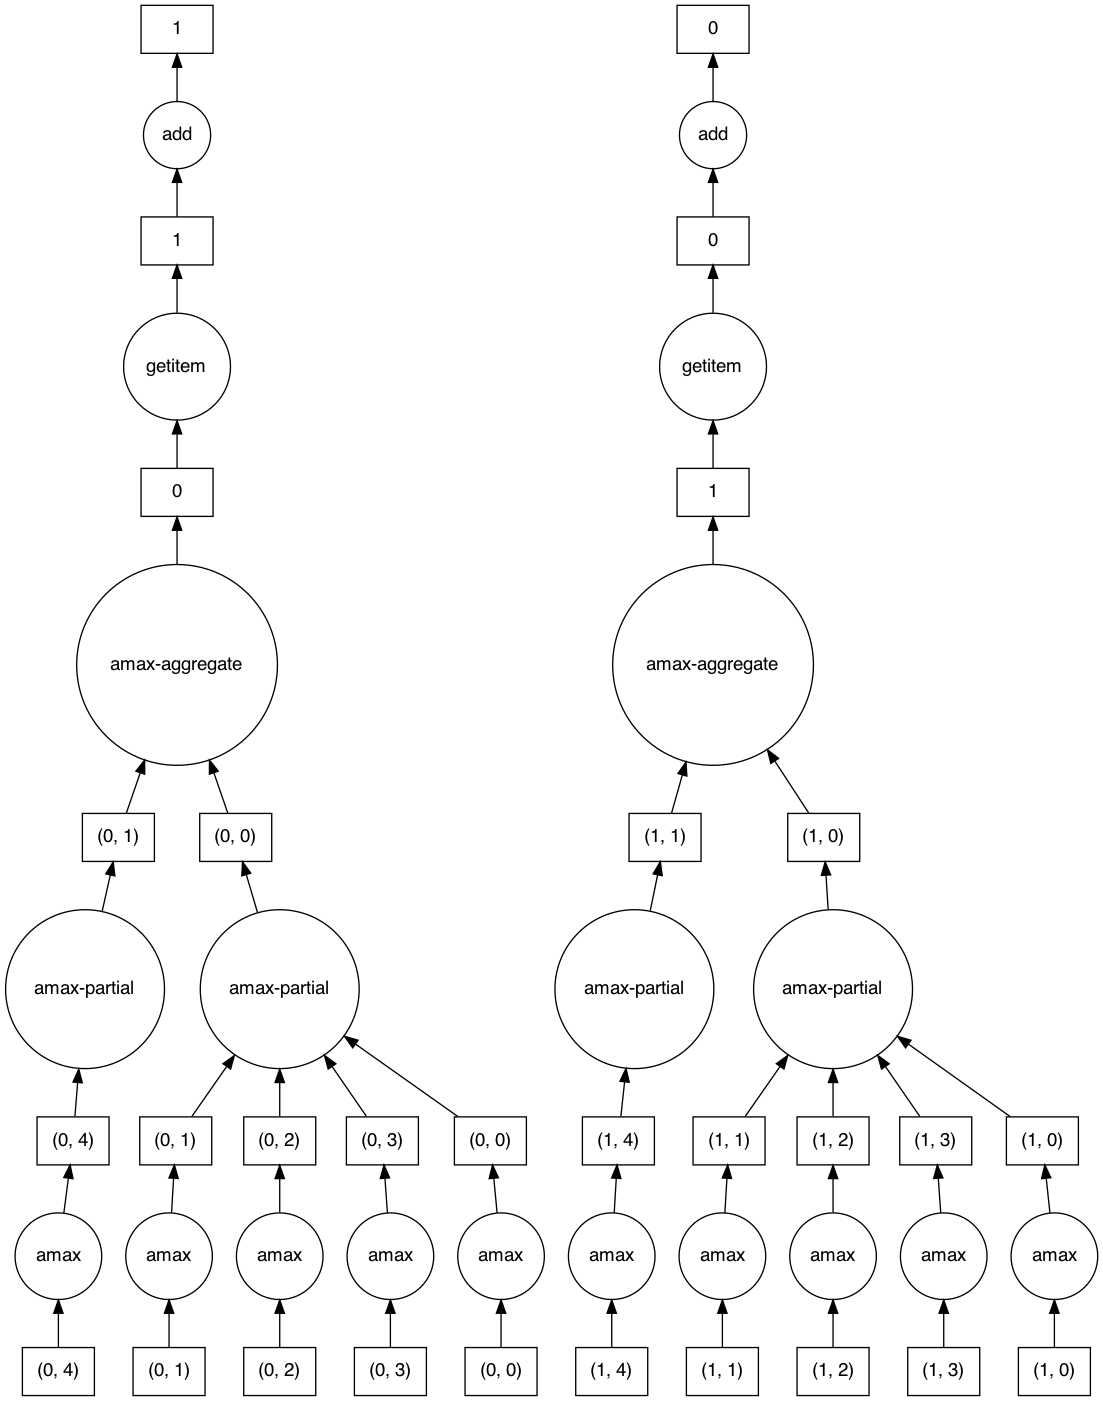

In [24]:
c.visualize()

### 底层API

使用`delayed`装饰器将函数调用包装到一个延迟构造的任务图中：

In [1]:
import dask

In [6]:
@dask.delayed
def inc(x):
    return x+1
@dask.delayed
def add(x, y):
    return x+y

In [10]:
a = inc(1)
b = inc(2)
c = add(a, b)

In [12]:
a, b, c

(Delayed('inc-171697d8-9c8e-42a6-b8f2-3a1c5ff36faa'),
 Delayed('inc-5a5d5200-1e59-4d9d-b0e5-049cad501cf4'),
 Delayed('add-3d37a606-f83d-401e-bacb-c16f9bec7c9a'))

In [13]:
c = c.compute()
c

5

### 调度

在生成任务图后，调度程序默认使用计算机线程池运行计算。

线程调度使用本地的`concurrent.futures.ThreadPoolExecutor`执行计算，是Dask Array，Dask DataFrame和Dask Delayed的默认选择。

由于Python的全局解释器锁 (GIL)，此调度程序仅在计算由非Python代码主导时提供并行性。主要是在NumPy数组、Pandas DataFrames中的数字数据上操作或使用任何生态系统中其他基于C/C++/Cython的项目。

In [3]:
# 对scheduler进行配置
dask.config.set(scheduler="threads")

In [5]:
dask.config.get("scheduler")

'threads'

进程调度使用本地的`concurrent.futures.ProcessPoolExecutor`执行计算，是Dask Bag的默认选择。

每个任务及其所有依赖项都被传送到本地进程执行，然后它们的结果被传送回主进程。可以绕过Python的GIL问题。但是将数据移动到进程可能会导致性能下降，尤其是在进程间传输大量数据时。当不涉及任务间数据传输，输出输入都很小时是一个很好的选择。

In [6]:
dask.config.set(scheduler='processes')

In [7]:
dask.config.get("scheduler")

'processes'

单线程同步调度器在一个本地线程中执行所有的计算，没有并行。一般用于调试或分析。比如Jupyter Notebook的魔法方法`%debug`，`%pdb`，`%prun`等在使用并行Dask调度时将无法正常工作。

In [8]:
dask.config.set(scheduler='synchronous') 

In [9]:
dask.config.get("scheduler")

'synchronous'

Dask支持使用分布式调度器进行更多控制，它可以在单台或多台机器上工作，可将其视为「高级调度器」。这也是目前比较推荐的方式。

之所以在单台机器上也推荐使用，原因在于：

- 提供异步API访问，尤其是Futures
- 提供诊断仪表板，可以提供有关性能和进度的意见
- 以更复杂的方式处理数据的局部性，在需要多个进程的工作负载上比多处理器调度器更有效

In [10]:
from dask.distributed import Client

In [11]:
client = Client()

In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63933,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:63957,Total threads: 1
Dashboard: http://127.0.0.1:63958/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:63939,


In [13]:
dask.config.get("scheduler")

'dask.distributed'

请注意上面`Dashboard`的地址，可以直接访问。

当然了，除了上面的这种全局配置方法，也可以使用上下文管理器，或执行`compute`时通过参数传入。

In [18]:
x = da.array([1,2])
x

dask.array<array, shape=(2,), dtype=int64, chunksize=(2,), chunktype=numpy.ndarray>

In [21]:
with dask.config.set(scheduler="threads"):
    xo = x.compute()

In [22]:
xo

array([1, 2])

In [23]:
dask.config.get("scheduler")

'dask.distributed'

In [25]:
x.compute(sheduler="threads")

array([1, 2])

更多关于分布式调度器的使用可参阅文档：

[Deploy Dask Clusters — Dask documentation](https://docs.dask.org/en/stable/deploying.html)

### 性能对比

In [7]:
%%time
rng = np.random.default_rng(42)
x = rng.normal(10, 0.1, size=(20000, 20000))
y = x.mean(axis=0)[::100]

CPU times: user 8.14 s, sys: 894 ms, total: 9.03 s
Wall time: 9.48 s


In [8]:
%%time
x = da.random.normal(
    10, 0.1, size=(20000, 20000), chunks=(1000, 1000)
)
y = x.mean(axis=0)[::100]
o = y.compute()

CPU times: user 26.1 s, sys: 596 ms, total: 26.7 s
Wall time: 8.75 s


In [9]:
x

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Dask完成的更快，但使用了更多的总CPU时间。

In [43]:
%%time
x = da.random.normal(
    10, 0.1, size=(20000, 20000), chunks=(20000, 20000)
)
y = x.mean(axis=0)[::100]
o = y.compute()

CPU times: user 39.3 s, sys: 8.38 s, total: 47.7 s
Wall time: 59.3 s


In [44]:
x

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(20000, 20000), chunktype=numpy.ndarray>

In [41]:
%%time
x = da.random.normal(
    10, 0.1, size=(20000, 20000), chunks=(25, 25)
)
y = x.mean(axis=0)[::100]
o = y.compute()

CPU times: user 3min 30s, sys: 36.4 s, total: 4min 7s
Wall time: 4min 16s


In [39]:
x

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>

## Xarray

文档：[xarray: N-D labeled arrays and datasets in Python](https://xarray.pydata.org/en/stable/index.html)

xarray在原始的类NumPy数组之上以维度、坐标和属性的形式引入标签，从而提供更直观、更简洁且不易出错的开发体验。

与之相关的工具包可参见：

[Installation](https://xarray.pydata.org/en/stable/getting-started-guide/installing.html)

xarray有两个核心的数据结构，它们构建在NumPy和Pandas之上，并进行了扩展，都是多维的：

- DataArray：有标签的N维数组
- Dataset：多维内存数组数据库

In [2]:
import xarray as xr
xr.__version__

'2022.3.0'

### 创建

In [106]:
rng = np.random.default_rng(42)
a = rng.normal(size=(2,3))
a

array([[ 0.30471708, -1.03998411,  0.7504512 ],
       [ 0.94056472, -1.95103519, -1.30217951]])

In [107]:
data = xr.DataArray(a, dims=("x", "y"), coords={"x": [10, 20]})

In [108]:
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.30471708, -1.03998411,  0.7504512 ],
       [ 0.94056472, -1.95103519, -1.30217951]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [109]:
data.x

<xarray.DataArray 'x' (x: 2)>
array([10, 20])
Coordinates:
  * x        (x) int64 10 20

In [110]:
data.y

<xarray.DataArray 'y' (y: 3)>
array([0, 1, 2])
Dimensions without coordinates: y

In [111]:
data.values

array([[ 0.30471708, -1.03998411,  0.7504512 ],
       [ 0.94056472, -1.95103519, -1.30217951]])

In [112]:
data.dims

('x', 'y')

In [113]:
data.coords

Coordinates:
  * x        (x) int64 10 20

In [114]:
data.attrs

{}

In [115]:
data.x.values

array([10, 20])

In [116]:
data.y.values

array([0, 1, 2])

### 索引

In [60]:
data[0,:]

<xarray.DataArray (y: 3)>
array([ 0.30471708, -1.03998411,  0.7504512 ])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

In [63]:
data.loc[10]

<xarray.DataArray (y: 3)>
array([ 0.30471708, -1.03998411,  0.7504512 ])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

In [68]:
data.loc[0]

KeyError: 0

In [70]:
# integer select
data.isel(x=0)

<xarray.DataArray (y: 3)>
array([ 0.30471708, -1.03998411,  0.7504512 ])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

In [71]:
data.isel(y=0)

<xarray.DataArray (x: 2)>
array([0.30471708, 0.94056472])
Coordinates:
  * x        (x) int64 10 20

In [73]:
# 直接select
data.sel(x=10)

<xarray.DataArray (y: 3)>
array([ 0.30471708, -1.03998411,  0.7504512 ])
Coordinates:
    x        int64 10
Dimensions without coordinates: y

更多介绍可参阅：

[Indexing and selecting data](https://xarray.pydata.org/en/stable/user-guide/indexing.html#indexing)

### 属性

在设置DataArray时，设置元数据属性通常是个不错的实践。常见的属性包括`long_name`，`units`等。

In [117]:
data.attrs["long_name"] = "random velocity"
data.attrs["units"] = "metres/sec"
data.attrs["description"] = "A random variable created as an example."

In [118]:
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.30471708, -1.03998411,  0.7504512 ],
       [ 0.94056472, -1.95103519, -1.30217951]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:    random velocity
    units:        metres/sec
    description:  A random variable created as an example.

In [119]:
data.attrs

{'long_name': 'random velocity',
 'units': 'metres/sec',
 'description': 'A random variable created as an example.'}

In [120]:
# 给坐标设置属性
data.x.attrs["units"] = "x units"

In [121]:
data.x

<xarray.DataArray 'x' (x: 2)>
array([10, 20])
Coordinates:
  * x        (x) int64 10 20
Attributes:
    units:    x units

### 计算

In [94]:
data + 10

<xarray.DataArray (x: 2, y: 3)>
array([[10.30471708,  8.96001589, 10.7504512 ],
       [10.94056472,  8.04896481,  8.69782049]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

In [95]:
np.sin(data)

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.3000233 , -0.86239618,  0.68196883],
       [ 0.80789103, -0.92857601, -0.96413891]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:    random velocity
    units:        metres/sec
    description:  A random variable created as an example.

In [96]:
data.T

<xarray.DataArray (y: 3, x: 2)>
array([[ 0.30471708,  0.94056472],
       [-1.03998411, -1.95103519],
       [ 0.7504512 , -1.30217951]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y
Attributes:
    long_name:    random velocity
    units:        metres/sec
    description:  A random variable created as an example.

In [97]:
data.sum()

<xarray.DataArray ()>
array(-2.29746581)

In [98]:
data.mean(dim="x")

<xarray.DataArray (y: 3)>
array([ 0.6226409 , -1.49550965, -0.27586416])
Dimensions without coordinates: y

与NumPy对比一下：

In [100]:
data.mean(axis=0)

<xarray.DataArray (y: 3)>
array([ 0.6226409 , -1.49550965, -0.27586416])
Dimensions without coordinates: y

In [99]:
data.mean(dim="y")

<xarray.DataArray (x: 2)>
array([ 0.00506139, -0.77088333])
Coordinates:
  * x        (x) int64 10 20

基于维度名称的广播（不需要插入虚拟尺寸进行对齐）：

In [15]:
[data.coords["y"]]

[<xarray.DataArray 'y' (y: 3)>
 array([0, 1, 2])
 Dimensions without coordinates: y]

In [28]:
rng = np.random.default_rng(42)
a = xr.DataArray(rng.integers(0, 10, 3), [data.coords["y"]])
b = xr.DataArray(rng.integers(0, 10, 4), dims="z")

In [29]:
a

<xarray.DataArray (y: 3)>
array([0, 7, 6])
Coordinates:
  * y        (y) int64 0 1 2

In [30]:
b

<xarray.DataArray (z: 4)>
array([4, 4, 8, 0])
Dimensions without coordinates: z

In [31]:
a + b

<xarray.DataArray (y: 3, z: 4)>
array([[ 4,  4,  8,  0],
       [11, 11, 15,  7],
       [10, 10, 14,  6]])
Coordinates:
  * y        (y) int64 0 1 2
Dimensions without coordinates: z

In [32]:
a.values + b.values

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

意味着大多数情况下不需要担心维度顺序：

In [13]:
data.shape

(2, 3)

In [12]:
data - data.T

<xarray.DataArray (x: 2, y: 3)>
array([[0., 0., 0.],
       [0., 0., 0.]])
Coordinates:
  * x        (x) int64 10 20
Dimensions without coordinates: y

更多可参阅：

[Computation](https://xarray.pydata.org/en/stable/user-guide/computation.html#comput)

### GroupBy

In [82]:
rng = np.random.default_rng(42)
a = xr.DataArray(rng.integers(1, 10, (2, 3)), dims=("x", "y"))
a

<xarray.DataArray (x: 2, y: 3)>
array([[1, 7, 6],
       [4, 4, 8]])
Dimensions without coordinates: x, y

In [83]:
labels = xr.DataArray(["E", "F", "E"], dims="y", name="labels")
labels

<xarray.DataArray 'labels' (y: 3)>
array(['E', 'F', 'E'], dtype='<U1')
Dimensions without coordinates: y

In [85]:
a.groupby(labels).mean("y")

<xarray.DataArray (x: 2, labels: 2)>
array([[3.5, 7. ],
       [6. , 4. ]])
Coordinates:
  * labels   (labels) object 'E' 'F'
Dimensions without coordinates: x

In [86]:
a.groupby(labels).mean("x")

<xarray.DataArray (y: 3)>
array([2.5, 5.5, 7. ])
Dimensions without coordinates: y

In [87]:
# 1 4 6 8 一组
# 7 4 一组
a.groupby(labels).map(lambda x: x - x.min())

<xarray.DataArray (x: 2, y: 3)>
array([[0, 3, 5],
       [3, 0, 7]])
Dimensions without coordinates: x, y

### 可视化

In [125]:
rng = np.random.default_rng(42)
a = xr.DataArray(
    rng.integers(1, 10, (2, 3)), 
    dims=("x", "y"),
    coords={"x": [10, 20], "y": [10, 20, 30]},
    attrs={
        "long_name": "random integers",
        "units": "null",
        "description": "demo random"
    }
)

In [126]:
a.x.attrs["units"] = "x 10-20"

In [127]:
a

<xarray.DataArray (x: 2, y: 3)>
array([[1, 7, 6],
       [4, 4, 8]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 10 20 30
Attributes:
    long_name:    random integers
    units:        null
    description:  demo random

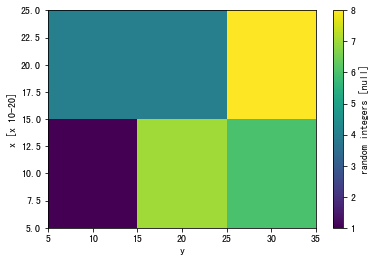

In [128]:
a.plot()

## 小结

## 参考

- [Beyond Numpy Arrays in Python](http://matthewrocklin.com/blog/work/2018/05/27/beyond-numpy)